In [1]:
import matplotlib.pyplot as plt
import time
import pickle
import scipy.stats
from scipy import interpolate
from copy import copy
import pandas as pd

In [2]:
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib
import itertools

In [3]:
from numba import jit, int64, float64,njit

In [4]:
%load_ext line_profiler

In [38]:
%%writefile GTN.py
import numpy as np
import numpy.linalg as nla
from copy import copy

class GTN:
    def __init__(self,L,history=True,seed=None):
        self.L=L
        self.C_m=self.correlation_matrix()
        self.C_m_history=[self.C_m]
        self.history=history
        self.rng=np.random.default_rng(seed)
    
    def correlation_matrix(self):
        Omega=np.array([[0,1],[-1,0]])
        return np.kron(np.eye(self.L),Omega)

    def measure(self,n,ix):
        ''' Majorana site index for ix'''
        if not hasattr(self,'n_history'):
            self.n_history=[]
        if not hasattr(self,'i_history'):
            self.i_history=[]

        m=self.C_m_history[-1].copy()
        for i_ind,i in enumerate(ix):
            m[[i,-(len(ix)-i_ind)]]=m[[-(len(ix)-i_ind),i]]
            m[:,[i,-(len(ix)-i_ind)]]=m[:,[-(len(ix)-i_ind),i]]
        proj=self.kraus(n)

        Psi=_contraction(m,proj,ix)
        assert np.abs(np.trace(Psi))<1e-5, "Not trace zero {:e}".format(np.trace(Psi))

        for i_ind,i in enumerate(ix):
            Psi[[i,-(len(ix)-i_ind)]]=Psi[[-(len(ix)-i_ind),i]]
            Psi[:,[i,-(len(ix)-i_ind)]]=Psi[:,[-(len(ix)-i_ind),i]]
        
        if self.history:
            self.C_m_history.append(Psi)
            self.n_history.append(n)
            self.i_history.append(ix)
        else:
            self.C_m_history=[Psi]
            self.n_history=[n]
            self.i_history=[ix]


    def projection(self,s):
        '''
        occupancy number: s= 0,1 
        (-1)^0 even parity, (-1)^1 odd parity

        '''
        assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
        blkmat=np.array([[0,-(-1)**s,0,0],
                        [(-1)**s,0,0,0],
                        [0,0,0,(-1)**s],
                        [0,0,-(-1)**s,0]])
        return blkmat

    def kraus(self,n):
        return -np.array([[0,n[0],n[1],n[2]],
                        [-n[0],0,-n[2],n[1]],
                        [-n[1],n[2],0,-n[0]],
                        [-n[2],-n[1],n[0],0]])
    
    def mutual_information_m(self,subregion_A,subregion_B):
        ''' Composite fermion site index'''
        assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
        s_A=self.von_Neumann_entropy_m(subregion_A)
        s_B=self.von_Neumann_entropy_m(subregion_B)
        subregion_AB=np.concatenate([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def von_Neumann_entropy_m(self,subregion):
        c_A=self.c_subregion_m(subregion)
        val=nla.eigvalsh(1j*c_A)
        self.val_sh=val
        val=np.sort(val)
        val=(1-val)/2+1e-18j   #\lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def c_subregion_m(self,subregion,Gamma=None):
        if not hasattr(self,'C_m'):
            self.covariance_matrix_f()
        if Gamma is None:
            Gamma=self.C_m_history[-1]
        subregion=self.linearize_index(subregion,2)
        return Gamma[np.ix_(subregion,subregion)]


    def linearize_index(self,subregion,n,k=2,proj=False):
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        if proj:
            return sorted(np.concatenate([n*subregion+i for i in range(0,n,k)]))
        else:
            return sorted(np.concatenate([n*subregion+i for i in range(n)]))

    def measure_all(self):
        proj_range=np.arange(self.L)*2 if even else np.arange(self.L)*2+1


    def measure_all(self,a1,a2,b1,b2,even=True,n1_z=True,Born=False):
        proj_range=np.arange(self.L)*2 if even else np.arange(self.L)*2+1
        if Born:
            Gamma_list=self.C_m_history[-1][proj_range,(proj_range+1)%(2*self.L)]
            n_list=get_Born(a1,a2,b1,b2,Gamma_list,n1_z=n1_z,rng=self.rng)
        else:
            n_list=get_random(a1,a2,b1,b2,proj_range.shape[0],n1_z=n1_z,rng=self.rng)
        for i,n in zip(proj_range,n_list):
            self.measure(n, np.array([i,(i+1)%(2*self.L)]))

    def mutual_information_cross_ratio(self):
        x=np.array([0,self.L//4,self.L//2,self.L//4*3])
        MI=[]
        subA=np.arange(x[0],x[1])
        subB=np.arange(x[2],x[3])
        for shift in range(self.L//2):
            MI.append(self.mutual_information_m((subA+shift)%self.L, (subB+shift)%self.L))
        return np.mean(MI)

def get_random(a1,a2,b1,b2,num,n1_z=True,rng=None):
    '''
        -b1<-a1<a2<b2 
        
        n1=True: nA=(n1,n2,n3)
        n1=True: nB=(n3,n1,n2)
    '''
    assert -b1<=-a1<=a2<=b2, "the order of -b1<-a1<a2<b2 not satisfied"
    rng=np.random.default_rng(rng)
    sign=rng.random(size=num)
    # inverse of CDF
    n1=np.where(sign<.5,sign*2*(b1-a1)-b1,(sign-1/2)*2*(b2-a2)+a2)

    # use rescale
    # n1=np.where(sign<0.5,rescale(sign,y0=-b1,y1=-a1,x0=0,x1=.5),rescale(sign,y0=a2,y1=b2,x0=.5,x1=1))
    # complete random
    # n1=np.random.uniform(b2,b1-a1+a2,num)
    # n1=np.where(n1<a2,n1,n1+(a1-a2))

    n2,n3=get_inplane(n1, num,rng=rng)
    return np.c_[n1,n2,n3] if n1_z else np.c_[n3,n1,n2]


def get_inplane(n1,num,rng=None):
    r=np.sqrt(1-n1**2)
    rng=np.random.default_rng(rng)
    phi=rng.random(num)*2*np.pi
    n2,n3=r*np.cos(phi),r*np.sin(phi)
    return n2,n3

def get_Born(a1,a2,b1,b2,Gamma,n1_z=True,rng=None):
    '''
        -b1<-a1<a2<b2 
        Gamma: list for all parities
        
        n1=True: nA=(n1,n2,n3)
        n1=True: nB=(n3,n1,n2)
    '''
    assert -b1<=-a1<=a2<=b2, "the order of -b1<-a1<a2<b2 not satisfied"
    num=Gamma.shape[0]
    rng=np.random.default_rng(rng)
    u=rng.random(size=num)
    theta1,theta2=(a2+b2)/((b1-a1)*(a1+a2+b1+b2)),(a1+b1)/((b2-a2)*(a1+a2+b1+b2))
    bndy=theta1*(-a1+b1+1/2*(a1**2-b1**2)*Gamma)
    coef1=1/2*theta1*Gamma,theta1,theta1*b1-1/2*theta1*b1**2*Gamma
    coef2=1/2*theta2*Gamma,theta2,theta1*(-a1+b1+(a1**2-b1**2)*Gamma/2)-a2**2*Gamma*theta2/2-theta2*a2

    n1=np.where(u<bndy,solve(coef1,u),solve(coef2,u))

    n2,n3=get_inplane(n1, num,rng=rng)
    return np.c_[n1,n2,n3] if n1_z else np.c_[n3,n1,n2]

def solve(coef,u):
    a,b,c=coef
    c=c-u
    with np.errstate(invalid='ignore'):
        n1=np.where(a==0,-c/b,(-b+np.sqrt(b**2-4*a*c))/(2*a) )
    return n1
    # return -c/b if a==0 else (-b+np.sqrt(b**2-4*a*c))/(2*a) 


def rescale(x,y0,y1,x0=0,x1=1):
    return (y1-y0)/(x1-x0)*(x-x0)+y0

def cross_ratio(x,L):
    if L<np.inf:
        xx=lambda i,j: (np.sin(np.pi/(L)*np.abs(x[i]-x[j])))
    else:
        xx=lambda i,j: np.abs(x[i]-x[j])
    eta=(xx(0,1)*xx(2,3))/(xx(0,2)*xx(1,3))
    return eta
# @jit(float64[:,:](float64[:,:],float64[:,:],int64[:]),nopython=True,fastmath=True)
def _contraction(m,proj,ix):
    
    Gamma_LL=m[:-len(ix),:-len(ix)]
    Gamma_LR=m[:-len(ix),-len(ix):]
    Gamma_RR=m[-len(ix):,-len(ix):]
    
    Upsilon_LL=proj[:len(ix),:len(ix)]
    Upsilon_RR=proj[len(ix):,len(ix):]
    Upsilon_RL=proj[len(ix):,:len(ix)]
    zero=np.zeros((m.shape[0]-len(ix),len(ix)))
    zero0=np.zeros((len(ix),len(ix)))

    # mat1=np.block([[Gamma_LL,zero],[zero.T,Upsilon_RR]])
    # mat2=np.block([[Gamma_LR,zero],[zero0,Upsilon_RL]])
    # mat3=np.block([[Gamma_RR,np.eye(len(ix))],[-np.eye(len(ix)),Upsilon_LL]])

    mat1,mat2,mat3=np.zeros(m.shape),np.zeros((m.shape[0],2*len(ix))),np.zeros((2*len(ix),2*len(ix)))
    mat1[:-len(ix),:-len(ix)]=Gamma_LL
    mat1[-len(ix):,-len(ix):]=Upsilon_RR
    mat2[:-len(ix),:len(ix)]=Gamma_LR
    mat2[-len(ix):,-len(ix):]=Upsilon_RL
    mat3[:len(ix),:len(ix)]=Gamma_RR
    mat3[len(ix):,len(ix):]=Upsilon_LL
    mat3[:len(ix),len(ix):]=np.eye(len(ix))
    mat3[len(ix):,:len(ix)]=-np.eye(len(ix))

    if np.count_nonzero(mat2):
        # Psi=mat1+mat2@(nla.solve(mat3,mat2.T))
        Psi=mat1+mat2@nla.inv(mat3)@mat2.T
        # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
    else:
        Psi=mat1
    
    Psi=(Psi-Psi.T)/2
    return Psi

Overwriting GTN.py


In [53]:
zz=get_random(a1=.8,a2= .6,b1=1,b2= 1,num= 10000,n1_z=True)

In [118]:
zz=get_Born(b2=.3,a2=.2, a1=.5,b1= 1,Gamma=np.linspace(-1,1,1000))

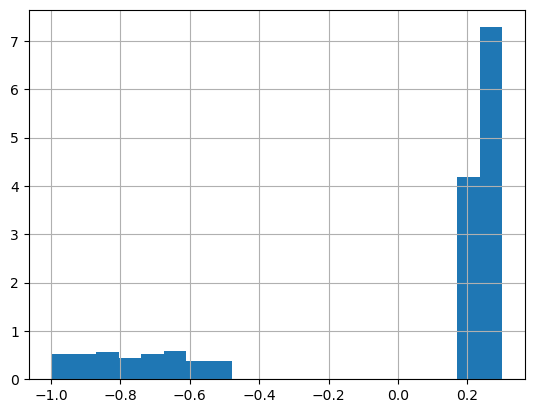

In [119]:
fig,ax=plt.subplots()
ax.hist(zz[:,0],bins=20,density=True)
ax.grid('on')

In [17]:
np.sum(zz[:,0]>0)

29

In [18]:
np.sum(zz[:,0]<0)

35

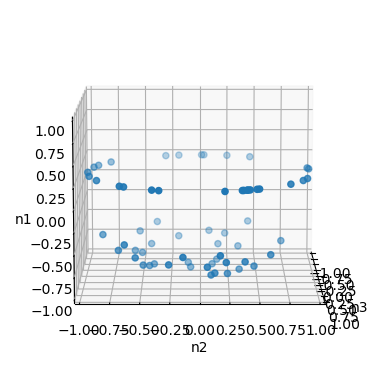

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
zz=np.array((gtn.n_history)[:64])
ax.scatter(zz[:,2],zz[:,1],zz[:,0])
ax.set_xlabel('n3')
ax.set_ylabel('n2')
ax.set_zlabel('n1')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.view_init(azim=0,elev=10)


In [10]:
rr=np.random.default_rng(0)

In [13]:
np.random.default_rng(rr)

Generator(PCG64) at 0x7F35190F36D0

In [12]:
rr

Generator(PCG64) at 0x7F35190F36D0

In [35]:
gtn=GTN(L=4,seed=2)

In [36]:
gtn.measure_all(b2=1,a2= 0, a1=0,b1= 1,Born=False,even=True,n1_z=True)
gtn.measure_all(b2=1,a2= 0, a1=0,b1= 1,Born=False,even=False,n1_z=False)

In [37]:
gtn.n_history

[array([-0.47677573, -0.71081965, -0.51712699]),
 array([-0.40301771, -0.12291136, -0.90690105]),
 array([0.62845148, 0.29585792, 0.71938642]),
 array([-0.81616812,  0.54347401,  0.19622846]),
 array([ 0.36681241, -0.45006126, -0.81418273]),
 array([-0.82970738,  0.31486603, -0.46091762]),
 array([ 0.46271811,  0.12453133, -0.87771516]),
 array([-0.53035478, -0.69987547, -0.478433  ])]

In [20]:
gtn.n_history

[array([ 0.02364325, -0.37869332,  0.92522017]),
 array([ 0.90092739, -0.38457694,  0.20107315]),
 array([-0.71168077,  0.32951213, -0.62042907]),
 array([ 0.89729889, -0.37151127,  0.23839898]),
 array([ 0.87279225,  0.09918738, -0.47790747]),
 array([-0.31791389, -0.94488177,  0.07828917]),
 array([ 0.81423329,  0.50702622, -0.28275176]),
 array([ 0.28720246,  0.07628663, -0.95482726])]

In [199]:
L=4

In [52]:
def profile():
    gtn=GTN(L=L)
    iteration=range(1)
    for i in iteration:
        gtn.measure_all(b2=1,a2= .9999, a1=.9999,b1= 1,Born=False,even=True,n1_z=True)
        gtn.measure_all(b2=1,a2= .9999, a1=.9999,b1= 1,Born=False,even=False,n1_z=False)

In [56]:
profile()

In [ ]:
%lprun -f GTN.measure profile()

In [23]:
L=64
iteration=np.arange(100)
MI=np.zeros((iteration.shape[0],))
gtn=GTN(L=L,seed=0)
for i in iteration:
    gtn.measure_all(b2=1,a2= .999, a1=.999,b1= 1,even=True,n1_z=True)
    gtn.measure_all(b2=1,a2= .999, a1=.999,b1= 1,even=False,n1_z=False)
    # MI[i]=(gtn.mutual_information_m(np.arange(gtn.L//2), gtn.L//2+np.arange(gtn.L//2)))
    MI[i]=gtn.mutual_information_cross_ratio()

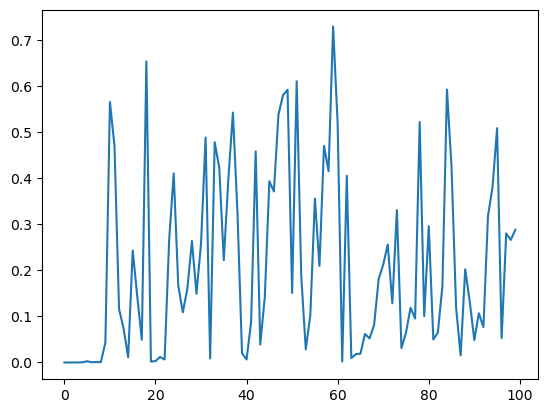

In [22]:
plt.plot(iteration,MI/np.log(2))

In [298]:
L=128
iteration=np.arange(100)
ensemble_size=10
MI=np.zeros((ensemble_size,iteration.shape[0],))
# gtn_list=[]
for ensemble in range(ensemble_size):
    gtn=GTN(L=L)
    for i in iteration:
        gtn.measure_all(b2=0,a2=0, a1=1,b1= 1,Born=False,even=True,n1_z=True)
        gtn.measure_all(b2=0,a2=0, a1=1,b1= 1,Born=False,even=False,n1_z=False)
        # MI[i]=(gtn.mutual_information_m(np.arange(gtn.L//2), gtn.L//2+np.arange(gtn.L//2)))
        MI[ensemble, i]=gtn.mutual_information_cross_ratio()

In [28]:
np.linspace(64,64,1)

array([64.])

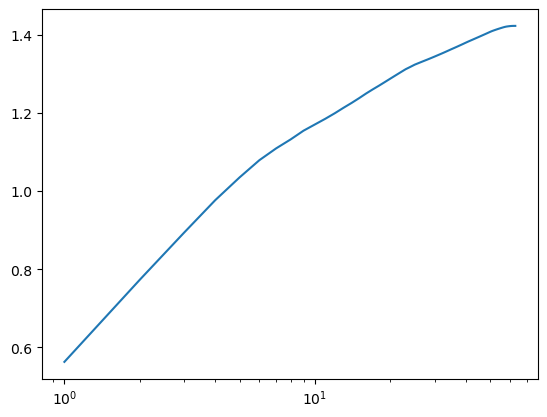

In [289]:
fig,ax=plt.subplots()
ax.plot(range(1,gtn.L//2),[np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+dl))%gtn.L) for i in range(gtn.L)]) for dl in range(1,gtn.L//2)])
ax.set_xscale('log')

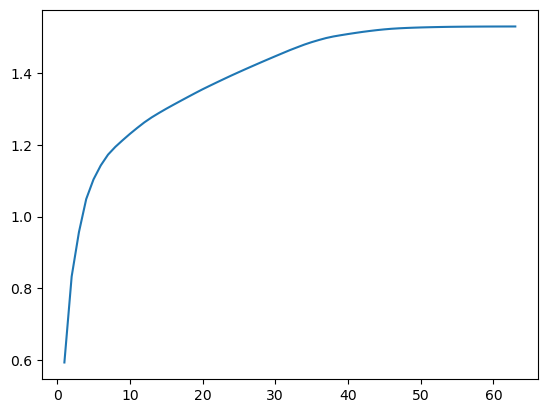

In [292]:
fig,ax=plt.subplots()
ax.plot(range(1,gtn.L//2),[np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+dl))%gtn.L) for i in range(gtn.L)]) for dl in range(1,gtn.L//2)])
# ax.set_xscale('log')

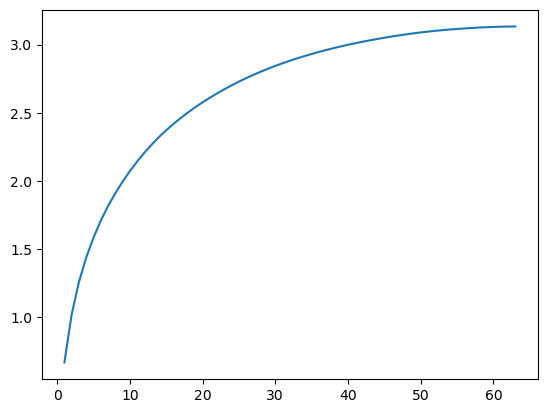

In [270]:
fig,ax=plt.subplots()
ax.plot(range(1,gtn.L//2),[np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+dl))%gtn.L) for i in range(gtn.L)]) for dl in range(1,gtn.L//2)])
# ax.set_xscale('log')

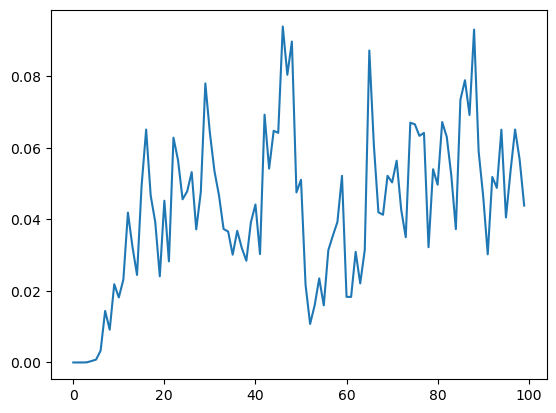

In [223]:
plt.plot(iteration,MI.mean(axis=0))

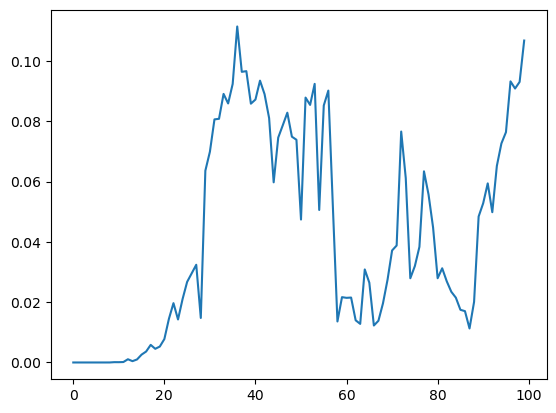

In [299]:
plt.plot(iteration,MI.mean(axis=0))

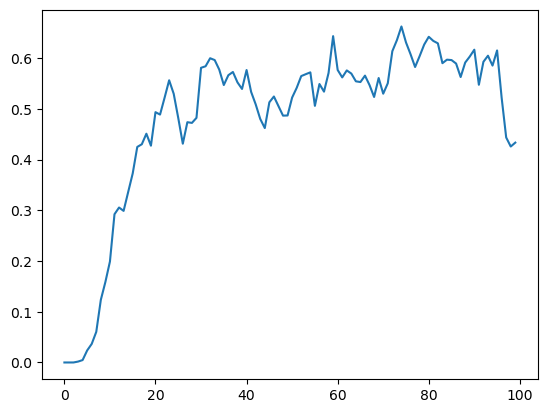

In [168]:
plt.plot(iteration,MI)

In [22]:
x=np.random.uniform(size=1000)

In [23]:
y=np.sqrt(x)

(array([ 29.,  38.,  45.,  77.,  92., 109., 131., 145., 171., 163.]),
 array([0.04806721, 0.14314844, 0.23822967, 0.3333109 , 0.42839213,
        0.52347336, 0.61855459, 0.71363582, 0.80871705, 0.90379828,
        0.99887951]),
 <BarContainer object of 10 artists>)

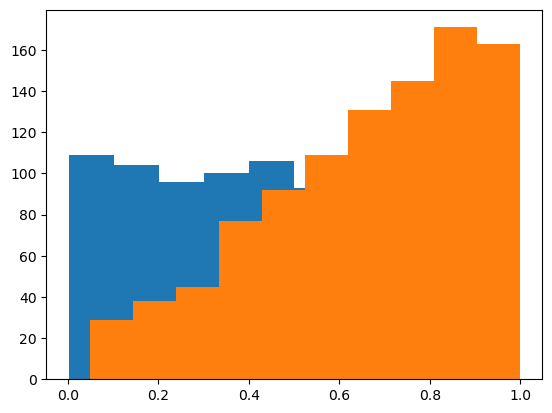

In [28]:
plt.hist(x)
plt.hist(y)

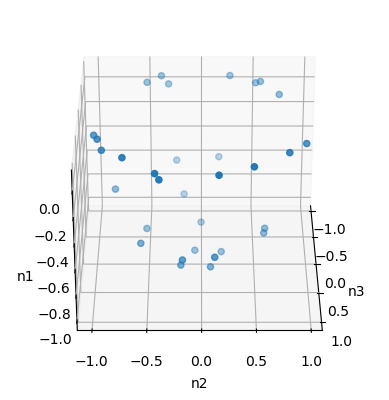

In [107]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
zz=np.array(gtn.n_history[:32])
ax.scatter(zz[:,2],zz[:,1],zz[:,0])
ax.set_xlabel('n3')
ax.set_ylabel('n2')
ax.set_zlabel('n1')
ax.view_init(azim=0)

In [309]:
gtn=GTN(L=128)
for r in range(10):
    for i in range(0,gtn.L,2):
        gtn.measure([1,0,0], [i,(i+1)%(2*gtn.L)])
    for i in range(1,gtn.L,2):
        gtn.measure([0,0,1], [i,(i+1)%(2*gtn.L)])
# gtn.measure_all_forced(b2=1,a2= 1, a1= 1,b1= 1,even=True,n1_z=True)
# mat1,mat2,mat3=gtn.measure(np.array([0,1,0]), [0,1])
# mat1,mat2,mat3=gtn.measure(np.array([-.99999,np.sqrt(1-.99999**2),0]), [0,1])

In [310]:
gtn.mutual_information_cross_ratio()

0.0

In [306]:
gtn.n_history

[[1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0,

In [271]:
mat1

array([[ 0.,  1.,  0.,  0.],
       [-1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [272]:
mat2

array([[ 0.,  0.,  0.,  0.],
       [-0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [273]:
mat3

array([[ 0.,  1.,  1.,  0.],
       [-1.,  0.,  0.,  1.],
       [-1., -0.,  0.,  0.],
       [-0., -1.,  0.,  0.]])

In [274]:
pd.DataFrame(np.linalg.inv(mat3))

,0,1,2,3
0,-0.0,-0.0,-1.0,-0.0
1,0.0,0.0,0.0,-1.0
2,1.0,0.0,0.0,1.0
3,-0.0,1.0,-1.0,-0.0


In [275]:
gtn.n_history

[array([0, 1, 0])]

In [276]:
gtn.C_m_history

[array([[ 0.,  1.,  0.,  0.],
        [-1.,  0., -0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [-0.,  0., -1.,  0.]]),
 array([[ 0.,  1.,  0.,  0.],
        [-1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [ 0.,  0., -1.,  0.]])]

In [296]:
L_list=2**np.arange(4,8)
iteration=np.arange(200)
MI=np.zeros((L_list.shape[0],iteration.shape[0]))
for L_i,L in enumerate(L_list):
    gtn=GTN(L=L)
    for i in iteration:
        gtn.measure_all_forced(b2=0.1,a2= 0, a1=.5,b1= 1,even=True,n1_z=True)
        gtn.measure_all_forced(b2=0.1,a2= 0, a1=.5,b1= 1,even=False,n1_z=False)
        MI[L_i,i]=gtn.mutual_information_cross_ratio()

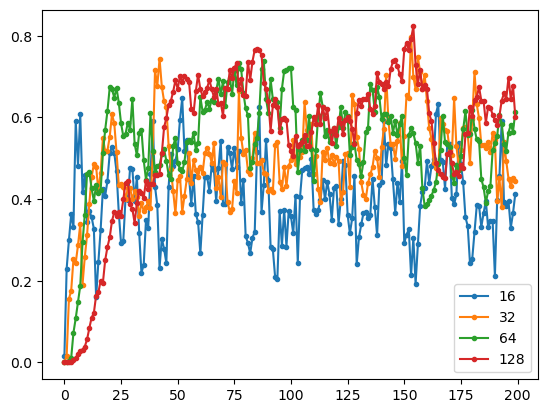

In [298]:
fig,ax=plt.subplots()
# ax.plot(L_list,np.mean(MI[:,-10:],axis=1),'.-')
for i in range(L_list.shape[0]):
    ax.plot(MI[i],'.-',label=str(L_list[i]))
ax.legend()
# ax.set_xscale('log')

In [299]:
L_list=2**np.arange(4,8)
iteration=np.arange(200)
MI_critical=np.zeros((L_list.shape[0],iteration.shape[0]))
for L_i,L in enumerate(L_list):
    gtn=GTN(L=L)
    for i in iteration:
        gtn.measure_all_forced(b2=1,a2= 0, a1=.5,b1= 1,even=True,n1_z=True)
        gtn.measure_all_forced(b2=1,a2= 0, a1=.5,b1= 1,even=False,n1_z=False)
        MI_critical[L_i,i]=gtn.mutual_information_cross_ratio()

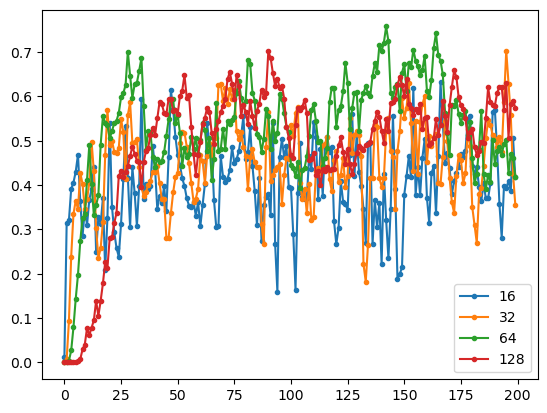

In [300]:
fig,ax=plt.subplots()
# ax.plot(L_list,np.mean(MI_critical[:,-10:],axis=1),'.-')
for i in range(L_list.shape[0]):
    ax.plot(MI_critical[i],'.-',label=str(L_list[i]))
ax.legend()
# ax.set_xscale('log')

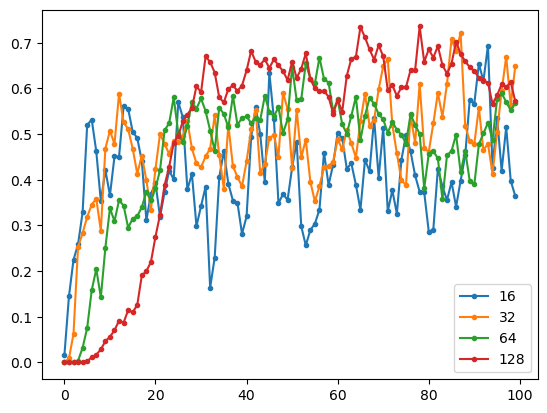

In [192]:
fig,ax=plt.subplots()
# ax.plot(L_list,np.mean(MI_critical[:,-10:],axis=1),'.-')
for i in range(L_list.shape[0]):
    ax.plot(MI_critical[i],'.-',label=str(L_list[i]))
ax.legend()
# ax.set_xscale('log')

In [255]:
gtn.measure(np.array([1,0,0]), [0,1])

In [257]:
gtn.measure(np.array([1,1,0]), [0,1])

In [285]:
# gtn.measure_all_forced(b2=-.9,a2= -.7, a1=.7,b1= .9)
gtn.measure_all_forced(b2=-.9,a2= -.7, a1=.7,b1= .9,even=False)

In [283]:
gtn.n_history

[array([ 0.70708212, -0.6158029 ,  0.34759411]),
 array([ 0.71292935, -0.07927067,  0.69674092]),
 array([-0.73656885,  0.6753321 ,  0.03732137]),
 array([-0.87550474, -0.06941651, -0.47819745])]

In [209]:
np.round(gtn.kraus(gtn.n_history[0]))

array([[-0.,  1., -0., -0.],
       [-1., -0.,  0., -0.],
       [ 0., -0., -0., -1.],
       [ 0.,  0.,  1., -0.]])

In [288]:
gtn.mutual_information_m([0,1],[2,3])/np.log(2)

2.718401573307823

In [286]:
gtn.C_m_history

[array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  0., -0.,  0., -0.,  0., -0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [-0.,  0., -1.,  0., -0.,  0., -0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [-0.,  0., -0.,  0., -1.,  0., -0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [-0.,  0., -0.,  0., -0.,  0., -1.,  0.]]),
 array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]]),
 array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0

In [287]:
np.round(gtn.C_m_history[-1]@gtn.C_m_history[-1]+np.eye(gtn.C_m_history[-1].shape[0]),4)

array([[ 0., -0., -0., -0.,  0., -0.,  0., -0.],
       [-0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [-0.,  0.,  0.,  0., -0.,  0., -0.,  0.],
       [-0.,  0.,  0.,  0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0.,  0., -0.,  0., -0.],
       [-0.,  0.,  0., -0., -0.,  0., -0.,  0.],
       [ 0., -0., -0., -0.,  0., -0.,  0.,  0.],
       [-0., -0.,  0., -0., -0.,  0.,  0.,  0.]])

In [154]:
zz=gtn.get_random(b2=-.8,a2= -.2, a1=.6,b1= .8,n= 100)

In [155]:
zz

array([[ 0.70119751,  0.22109219, -0.67782025],
       [-0.47606129, -0.85122594,  0.22086206],
       [-0.54611007,  0.83747523, -0.01997562],
       [-0.6676215 ,  0.65284639, -0.35787306],
       [ 0.64531027, -0.53599815,  0.54431667],
       [ 0.66289005,  0.70583412, -0.24974982],
       [-0.40978067,  0.60542324,  0.68230675],
       [-0.6123901 ,  0.36461803, -0.70144997],
       [-0.60270724,  0.2228029 , -0.76622637],
       [-0.38271209, -0.07799474,  0.92056954],
       [-0.26409525, -0.80819312,  0.52638159],
       [-0.601173  ,  0.7936046 , -0.09371639],
       [-0.67677914, -0.56841175, -0.46784407],
       [ 0.65793901, -0.70672265, -0.2601141 ],
       [-0.29417646, -0.6118983 ,  0.7341939 ],
       [ 0.68633131,  0.32151399, -0.65236346],
       [-0.43842451, -0.8666208 ,  0.2382275 ],
       [-0.62234816,  0.28399222,  0.72940468],
       [-0.77429458, -0.57677726,  0.26037644],
       [-0.23630149, -0.3956249 ,  0.88749228],
       [-0.67793996,  0.00213845, -0.735

In [156]:
np.linalg.norm(zz,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

(array([646., 675., 635., 655., 646., 684., 672., 722., 665., 636., 689.,
        162.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 511., 678., 641., 683.]),
 array([-7.99993005e-01, -7.46663848e-01, -6.93334691e-01, -6.40005535e-01,
        -5.86676378e-01, -5.33347221e-01, -4.80018065e-01, -4.26688908e-01,
        -3.73359751e-01, -3.20030595e-01, -2.66701438e-01, -2.13372281e-01,
        -1.60043125e-01, -1.06713968e-01, -5.33848111e-02, -5.56544542e-05,
         5.32735022e-02,  1.06602659e-01,  1.59931816e-01,  2.13260972e-01,
         2.66590129e-01,  3.19919286e-01,  3.73248442e-01,  4.26577599e-01,
         4.79906756e-01,  5.33235912e-01,  5.86565069e-01,  6.39894226e-01,
         6.93223383e-01,  7.46552539e-01,  7.99881696e-01]),
 <BarContainer object of 30 artists>)

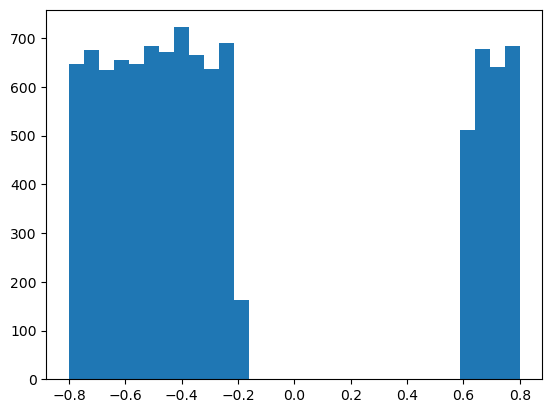

In [124]:
plt.hist(zz,30)

In [97]:
gtn.kraus(np.array([1,0,0]),theta=0)

array([[ 0.,  1.,  0.,  0.],
       [-1.,  0., -0.,  0.],
       [-0.,  0.,  0., -1.],
       [-0., -0.,  1.,  0.]])

In [77]:
gtn.C_m

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0., -0.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [-0.,  0., -1.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-0.,  0., -0.,  0., -1.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [-0.,  0., -0.,  0., -0.,  0., -1.,  0.]])

In [67]:
gtn.C_m=np.array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [72]:
gtn.C_m_history=[np.array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])]

In [56]:
gtn.measure(0, [0,1])

In [57]:
gtn.i_history

[[0, 1], [0, 1]]

In [73]:
gtn.C_m_history

[array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])]

In [25]:
gtn.measure(0, [0,1])

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0., -0.,  0., -1.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -0.,  0., -0.,  0., -1.,  0.]])

In [19]:
gtn.measure(1, [1,2])

array([[ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [60]:
gtn.von_Neumann_entropy_m([0,1])

In [75]:
gtn.mutual_information_m([0,1],[2,3])/np.log(2)

2.0

## Results

In [39]:
import pickle

In [56]:
with open('GTN_a1(0.50,0.50,1)_a2(0.00,0.99,3)_b1(1.00,1.00,1)_b2(1.00,1.00,1)_En10_L64_t64.pickle','rb') as f:
    rs=pickle.load(f)

In [57]:
rs['MI']

array([[[[[5.34930268e-01, 5.12724246e-01, 5.21051890e-01,
           3.78899784e-01, 4.88208458e-01, 3.68155644e-01,
           2.95343834e-01, 5.72998790e-01, 3.87926835e-01,
           4.61489679e-01]]],


        [[[2.94837497e-01, 4.52231408e-01, 4.09681630e-01,
           3.56211882e-01, 3.83134685e-01, 2.44557651e-01,
           2.10717734e-01, 4.00348471e-01, 2.56500704e-01,
           2.60293487e-01]]],


        [[[2.75383378e-03, 1.88000930e-03, 1.12325005e-06,
           3.50104796e-05, 3.58217193e-07, 1.38587909e-08,
           2.65846653e-03, 1.39310617e-01, 1.01578417e-04,
           9.67001293e-04]]]]])

In [58]:
rs['MI'].shape

(1, 3, 1, 1, 10)

In [59]:
rs['MI'].mean(axis=-1)

array([[[[0.45217294]],

        [[0.32685151]],

        [[0.0147708 ]]]])

In [60]:
rs['params']

KeyError: 'params'

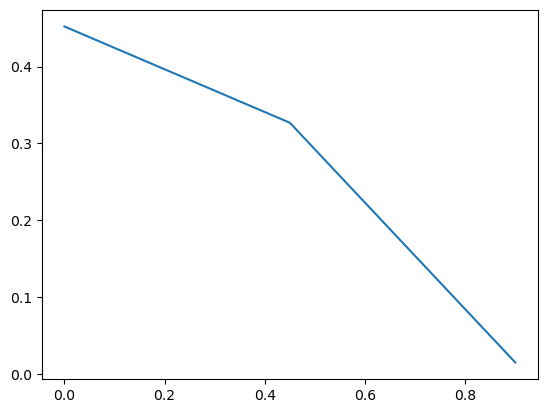

In [61]:
plt.plot(np.linspace(0,0.9,3),np.squeeze(rs['MI'].mean(axis=-1)))